Prophet is a forecasting tool from Facebook which is optimized for creating business forecasts of time series data. 


Prophet is an open source forecasting tool built by Facebook. It can be used for time series modeling and forecasting trends into the future. Prophet is interesting because it's both sophisticated and quite easy to use, so it's possible to generate very good forecasts with relatively little effort or domain knowledge in time series analysis.


But instead of using the traditional way of building the model such as using [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), it is fitting additive regression models or known as ‘curve fitting’. 


https://facebook.github.io/prophet/docs/quick_start.html

## The forecasting model

The library gives us possibility to forecast time series data based on an additive regression model where non-linear trends are fit with yearly, weekly and daily seasonality. It also takes into account holiday effects and works best with time series that have strong seasonal effects and several seasons of historical data.

As stated above this library utilizes an additive regression model **y(t)** comprising the following components:

$\large
y(t)=g(t)+s(t)+h(t)+ϵt,
$

Where:

* Trend **g(t)** models non-periodic changes.
* Seasonality **s(t)** represents periodic changes(e.g. weekly/yearly seasonality).
* Holidays component **h(t)** contributes information about holidays and events (user provided) with irregular schedules.
* Error term **εt** accounts for any unusual changes not accommodated by the model

For a more in depth look at some of the important properties of these model components see the white paper which is located [here](https://peerj.com/preprints/3190/).

* 3.1  The Trend Model
* 3.2  Seasonality
* 3.3  Holidays and Events

{{< youtube pOYAXv15r3A >}}

## Installation

Before we open up a new project we need to install Prophet and Stan. The statistical modeling for this library is handled by the Stan library and is a prerequisite for Prophet. Prophet is available in both R and Python. Both libraries have identical features and for this article i've chosen Python since it is my preferred language of choice. If you're using Python the easiest way to install Prophet is via Anaconda or pip. In R you can find the corresponing CRAN package [here](https://cran.r-project.org/web/packages/prophet/index.html). For the full implementation guide visit the official documentation on installing the library [here](https://facebook.github.io/prophet/docs/installation.html).


There are a few requirements you’ll need to meet in order to use the library. It uses PyStan to do all of its inference, so PyStan has to be installed. PyStan has its own dependencies, including a C++ compiler. Python 3 also appears to be a requirement. Full installation instructions are here.


Head over to your terminal and copy paste the following two commands:

```plaintext
conda install -c conda-forge pystan
conda install -c conda-forge fbprophet
```

Or if you're using pip:

```plaintext
pip install pystan
pip install fbprophet
```

When the installation is done we can start by importing the following modules which we'll need for this project:

In [ ]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from  fbprophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.getLogger().setLevel(logging.ERROR)

## Preparing the dataset

The dataset we're using for this forecast is exported from [Google Analytics](https://marketingplatform.google.com/about/analytics/) and gives us a table with daily session data. A session is not equal to a server hit or pageview and if you´re not familiar with this way of measuring webtraffic you can read up on Googles definition of a session [here](https://support.google.com/analytics/answer/2731565?hl=en). For this forecast we'll keep it simple and look at all website traffic since this is data which one of my clients let me use for this article. Keep in mind that where Prophet really shines is in seasonal/holiday data which would make this a perfect tool to use when forecasting paid campaigns over the christmas holidays, blackfriday or any other of the major holidays where brands would do yearly sales pushes.

Lets start with loading the dataset:

In [ ]:
df = pd.read_excel("Analytics Ecomm - filtrerad Channels 20140101-20171231.xlsx")
df.head()

Nothing out of the ordinary here. We have one column with dates and one column with sessions.

Prophet's API is very similar to the one you can find in sklearn. First we create a model, then call the method fit, and, finally, make a forecast. The input to the method fit is a DataFrame with two columns:

* **ds** (datestamp) must be of type date or datetime.
* **y** is a numeric value we want to predict.

First we'll rename the columns in order to comply with the API:

In [3]:
df.columns = ["ds", "y"]
df.head()

,ds,y
0,2014-01-01,50243
1,2014-01-02,72584
2,2014-01-03,67954
3,2014-01-04,55061
4,2014-01-05,59354


And then we'll make sure that the newly renamed **ds** column is of type datetime:

In [4]:
df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

Now lets make simple pandas plot to see if we can get some insights:

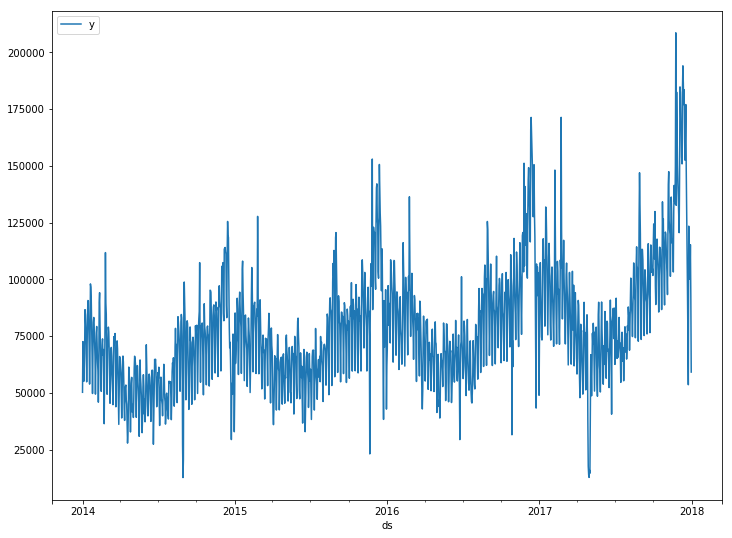

In [5]:
df = df.set_index('ds')
df.plot(figsize=(12,9));

Plotting it by day creates a lot of noise and there's a few big drops in traffic over the years that i would like to look into further before continuing. So let's resample the data by week instead to reduce noise and make it more clear on what we're looking at:

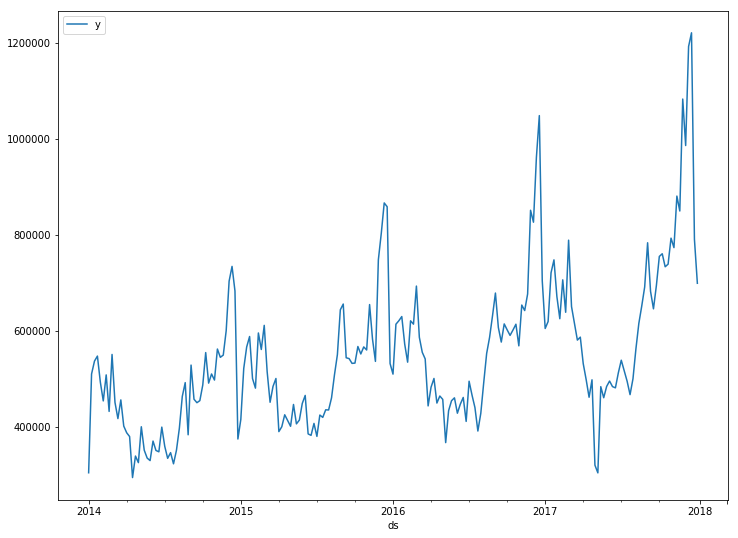

In [6]:
df.resample('W').apply(sum).plot(figsize=(12,9));

At the end of April in 2017 there's a big drop in traffic which after further investigation turned out to be a malfunctioning tracking pixel between the dates 2014-04-27 and 2017-05-03. To keep it simple i'm going to backfill this data with the data from the year before so that we don't include this anomaly in our forecast.

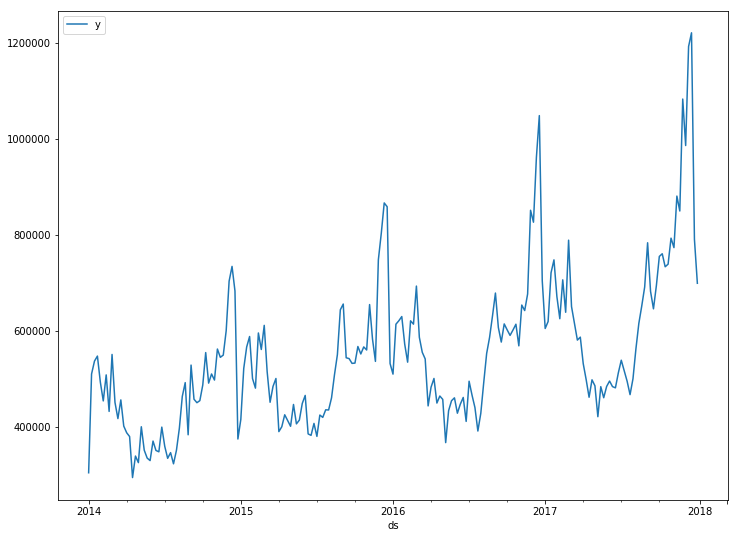

In [7]:
df.loc ['2017-04-27':'2017-05-03', 'y'] = [72321, 71661, 62175, 41344, 52864, 66320, 66950]
df.resample('W').apply(sum).plot(figsize=(12,9));

Now this looks pretty good but we do have one more transformation that we wan't to do before we start with our forecast.

We will convert the **y** column (Sessions) to it's logarithmic value. This article has more information on why a log transform is useful for these types of data sets. From the article:

> … logging converts multiplicative relationships to additive relationships, and by the same token it converts exponential (compound growth) trends to linear trends. By taking logarithms of variables which are multiplicatively related and/or growing exponentially over time, we can often explain their behavior with linear models.

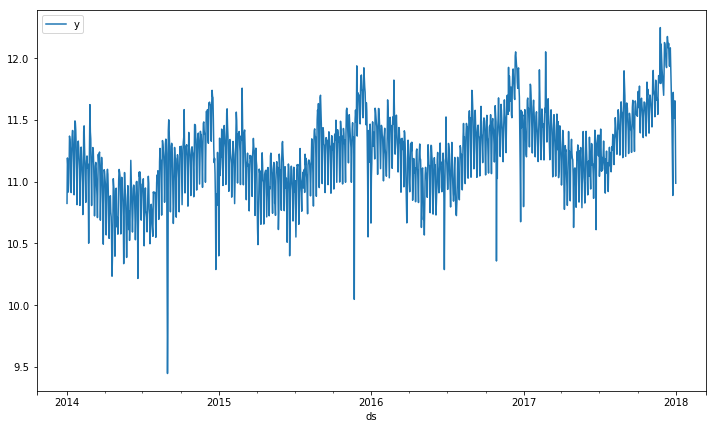

In [8]:
df['y'] = np.log(df['y'])
df.plot(figsize=(12,7));

Finally, let's reset the index so that we can fit the model correctly:

In [9]:
df.reset_index(inplace=True)

## Making the forecast

P

In [10]:
# Declaring Prophet with daily seasonality set to true
m = Prophet()

In [11]:
# Load dataframe in Prophet
m.fit(df);

In [12]:
# Creating a future dataframe over a 365 day period
future = m.make_future_dataframe(periods=365)

In [13]:
# Predicting future dataframe
forecast = m.predict(future)

In [14]:
# Output of the forecast dataframe
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1821,2018-12-27,11.836365,11.622486,12.034487
1822,2018-12-28,11.697471,11.486655,11.902744
1823,2018-12-29,11.499832,11.295791,11.692263
1824,2018-12-30,11.722128,11.515439,11.917646
1825,2018-12-31,11.900879,11.681857,12.105430


In the resulting dataframe you can see many columns characterizing the prediction, including trend and seasonality components as well as their confidence intervals. The forecast itself is stored in the yhat column.

The Prophet library has its own built-in tools for visualization that enable us to quickly evaluate the result. First, there is a method called Prophet.plot that plots all the points from the forecast:

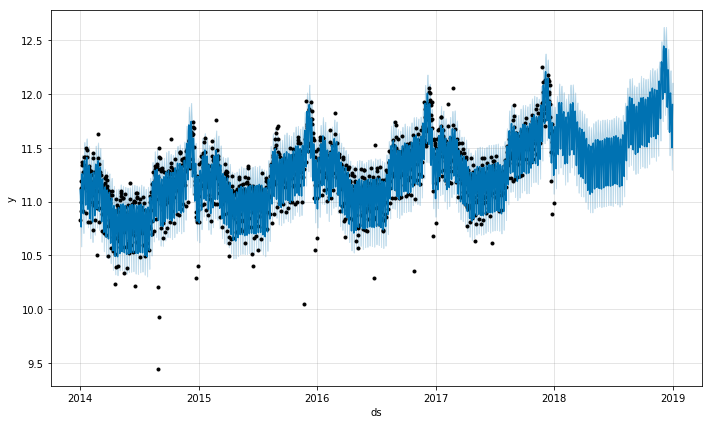

In [15]:
# Plotting the forecast data
m.plot(forecast);

This chart doesn't look very informative. The only definitive conclusion that we can draw here is that the model treated many of the data points as outliers.

Changepoints

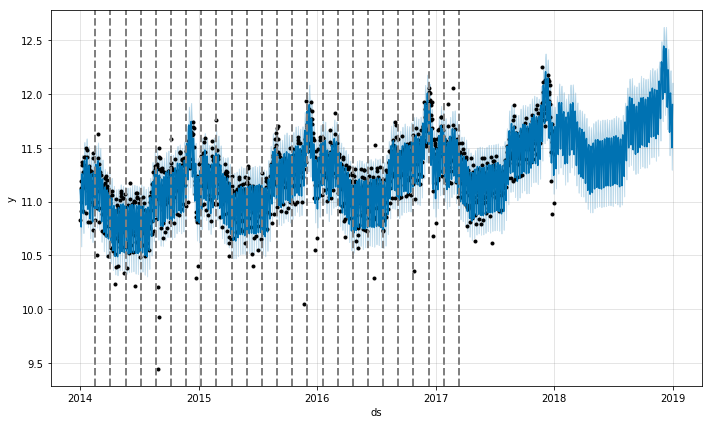

In [16]:
m.plot(forecast);
for cp in m.changepoints:
    plt.axvline(cp, c='gray', ls='--', lw=2)

Changepoints

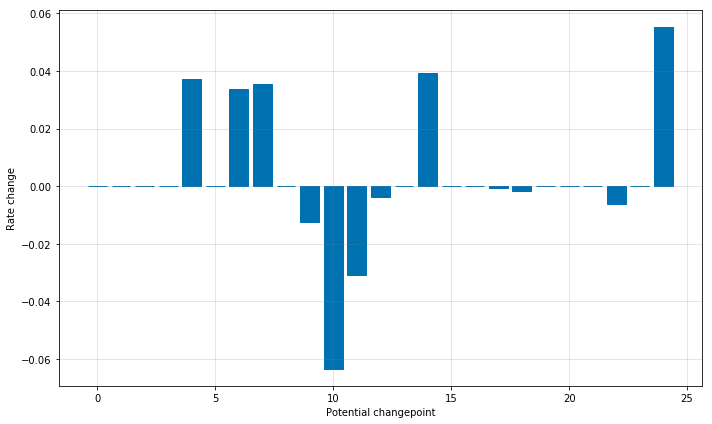

In [17]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

Changepoints

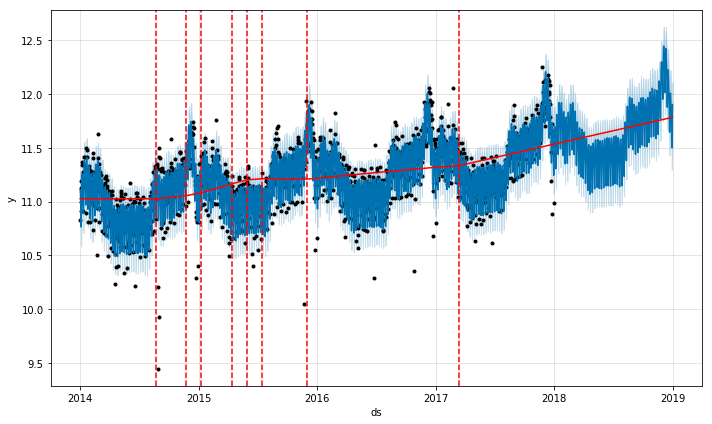

In [18]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

Changepoints

The second function Prophet.plot_components might be much more useful in our case. It allows us to observe different components of the model separately: trend, yearly and weekly seasonality. In addition, if you supply information about holidays and events to your model, they will also be shown in this plot.

Let's try it out without any additional data first:

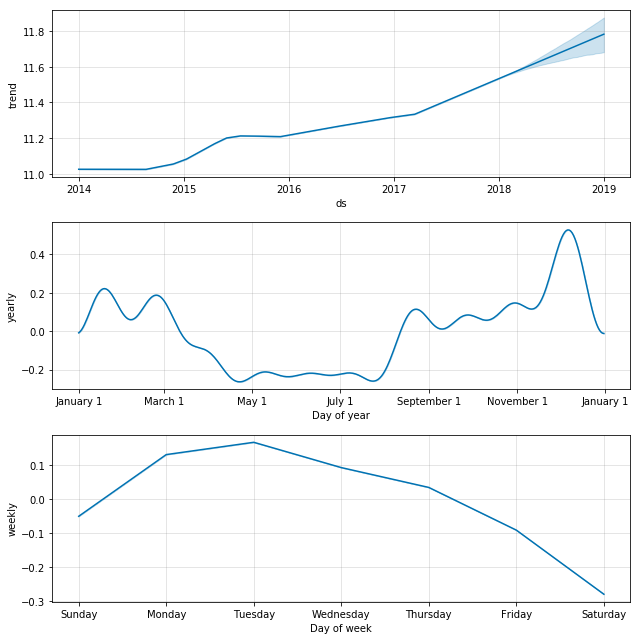

In [19]:
# Plotting more granular data
m.plot_components(forecast);

**As you can see from the trend graph, Prophet did a good job by fitting the accelerated growth of traffic at the end of 2017. **

## Supplying the model with holiday dates

It is possible to feed the model with future holiday dates

In addition to the above components, Prophet can also incorporate possible effects from holidays. Holidays and dates for each holiday have to be manually specified over the entire range of the data set (including the forecast period). The way holidays get defined and incorporated into the model is fairly simple.

In [20]:
holidays = pd.DataFrame({
  'holiday': 'holiday',
  'ds': pd.to_datetime(['2014-01-01', '2014-01-06', '2014-04-18', '2014-04-20', '2014-04-21', '2014-05-01', 
                        '2014-05-29', '2014-06-06', '2014-06-08', '2014-06-21', '2014-11-01', '2014-12-25', 
                        '2014-12-26', '2015-01-01', '2015-01-06', '2015-04-03', '2015-04-05', '2015-04-06',
                        '2015-05-01', '2015-05-14', '2015-05-24', '2015-06-06', '2015-06-20', '2015-10-31',
                        '2015-12-25', '2015-12-26', '2016-01-01', '2016-01-06', '2016-03-25', '2016-03-27', 
                        '2016-03-28', '2016-05-01', '2016-05-05', '2016-05-15', '2016-06-06', '2016-06-25',
                        '2016-11-05', '2016-12-25', '2016-12-26', '2017-01-01', '2017-01-06', '2017-04-14',
                        '2017-04-16', '2017-04-17', '2017-05-01', '2017-05-25', '2017-06-04', '2017-06-06',
                        '2017-06-24', '2017-11-04', '2017-12-25', '2017-12-26', '2018-01-01', '2018-01-06', 
                        '2018-03-30', '2018-04-01', '2018-04-02', '2018-05-01', '2018-05-10', '2018-05-20', 
                        '2018-06-06', '2018-06-23', '2018-11-03', '2018-12-25', '2018-12-26',]),
  'lower_window': 0,
  'upper_window': 3,
})
holidays.head()

,ds,holiday,lower_window,upper_window
0,2014-01-01,holiday,0,3
1,2014-01-06,holiday,0,3
2,2014-04-18,holiday,0,3
3,2014-04-20,holiday,0,3
4,2014-04-21,holiday,0,3


Once we have holidays defined in a data frame, using them in the model is just a matter of passing in the data frame as a parameter when we define the model.

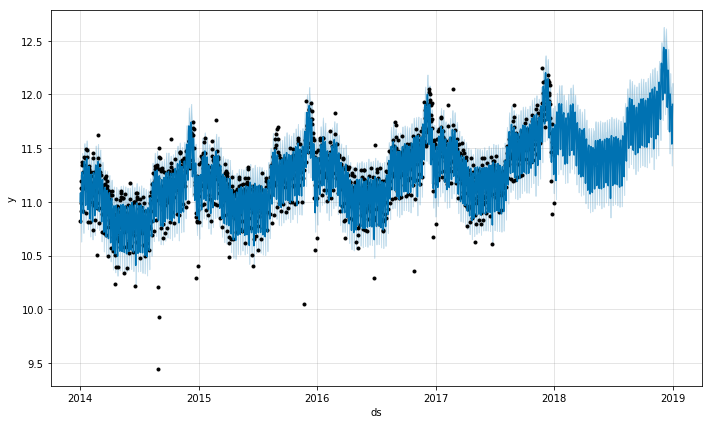

In [21]:
m2 = Prophet(holidays=holidays).fit(df)
future2 = m2.make_future_dataframe(periods=365)
forecast2 = m2.predict(future2)
m2.plot(forecast2);

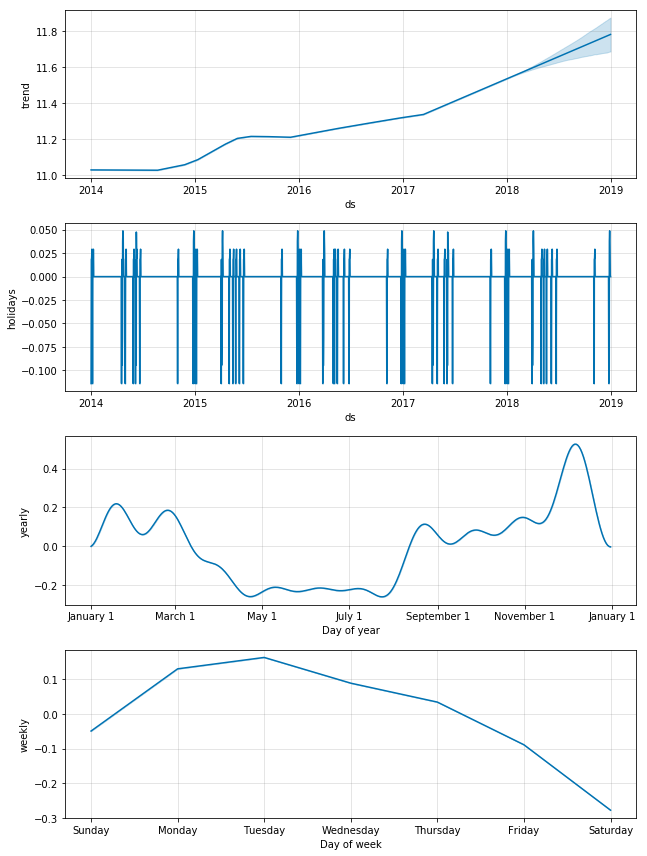

In [22]:
m2.plot_components(forecast2);

Our component plot now includes a holidays component with spikes indicating the magnitude of influence those holidays have on the value.

## To be continued..

In this first part we took a look at how you in very simple way can get up and running with the library. Prophet is fairly straight forward to work with for someone that doesn't have much experience in forecasting timeseries data.

In the next part we´ll look further into the prophet components. We'll also do an evaluation of the quality of our forecast and we'll take a look on how you can improve the model.

But before we close this project let's export the data for use in the next article:

In [23]:
forecast.to_excel('projected_data.xlsx')

## Sources

* ht<span>tps://medium.com/@ravindraprasad/retail-sales-forecast-using-facebooks-prophet-a47f8597ccd0